In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

[*********************100%%**********************]  10 of 10 completed


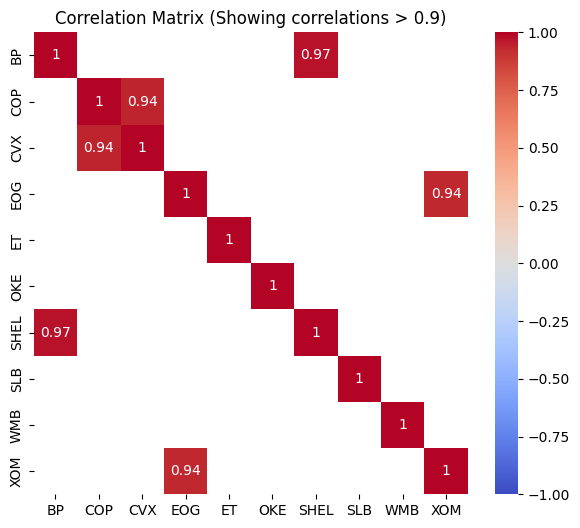

In [31]:
tickers_energy = ['BP', 'SHEL', 'COP', 'EOG', 'WMB', 'SLB', 'ET', 'OKE', 'CVX', 'XOM']
# Second pair:
# tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']
# Third pair:
# tickers_energy = [ 'NNN', 'ADC', 'AVB', 'ESS', 'AMT', 'DLR', 'LAMR', 'DLR','ARE','O']
startDateStr = '2015-01-01'
endDateStr = '2023-12-31'

data1 = yf.download(tickers_energy, startDateStr, endDateStr)['Adj Close']
data1
data_log1 = np.log(data1)
import seaborn as sns
correlation_matrix1 = data_log1.corr()

# Create a mask for correlations below 0.9
mask = np.abs(correlation_matrix1) < 0.9

# Plot the heatmap for correlations greater than 0.9
plt.figure(figsize=(7, 6))
sns.heatmap(correlation_matrix1, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix (Showing correlations > 0.9)')
plt.show()

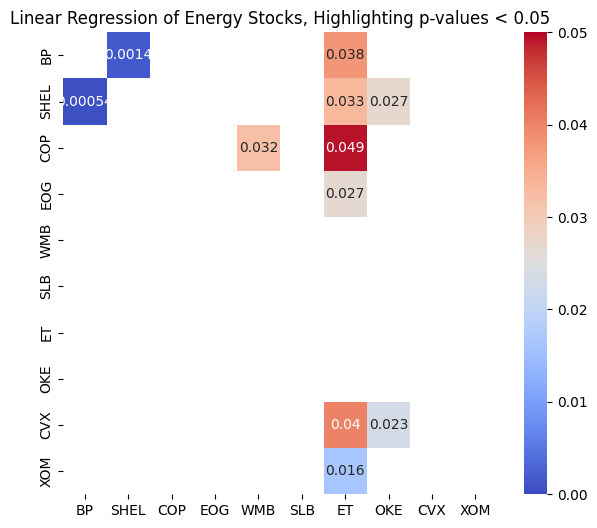

In [32]:
# ACF testing and p-value by linear regression
pvalue_matrix = pd.DataFrame(index=tickers_energy, columns=tickers_energy)

# Function to calculate p-value from ADF test of residuals
def calculate_adf_pvalue(X, Y):
    # Fit linear regression
    model = LinearRegression()
    model.fit(X, Y)
    Y_pred = model.predict(X)

    # Calculate residuals
    residuals = Y - Y_pred

    # Perform ADF test on residuals
    adf_test = adfuller(residuals)

    # Return the p-value
    return adf_test[1]

# Loop over all pairs of stocks
for i, stock1 in enumerate(tickers_energy):
    for j, stock2 in enumerate(tickers_energy):
        if i != j:
            # Independent variable (X)
            X = data_log1[stock1].values.reshape(-1, 1)  # Reshaped for sklearn

            # Dependent variable (Y)
            Y = data_log1[stock2].values

            # Calculate the ADF p-value of the residuals
            pvalue = calculate_adf_pvalue(X, Y)

            # Store the p-value in the matrix
            pvalue_matrix.loc[stock1, stock2] = pvalue

# Convert the DataFrame to float type for heatmap plotting
pvalue_matrix = pvalue_matrix.astype(float)

# Create a mask for p-values >= 0.05 (we want to highlight p-values < 0.05)
mask = pvalue_matrix >= 0.05

# Plot the heatmap for p-values less than 0.05
plt.figure(figsize=(7, 6))
sns.heatmap(pvalue_matrix, mask=mask, annot=True, cmap='coolwarm', vmin=0, vmax=0.05)
plt.title('Linear Regression of Energy Stocks, Highlighting p-values < 0.05')
plt.show()

#### This heatmap visualizes the results of linear regression analyses between various energy stocks, highlighting statistically significant relationships where the p-value is less than 0.05.

#### We chose SHEL and BP: A strong significant negative relationship with a p-value of 0.0014.

[*********************100%%**********************]  2 of 2 completed

--- Correlation Result---
Correlation of Log Price between BP and SHEL:, 0.9716

--- Correlation Matrix of returns for energy stocks---
            BP      SHEL
BP    1.000000  0.893537
SHEL  0.893537  1.000000


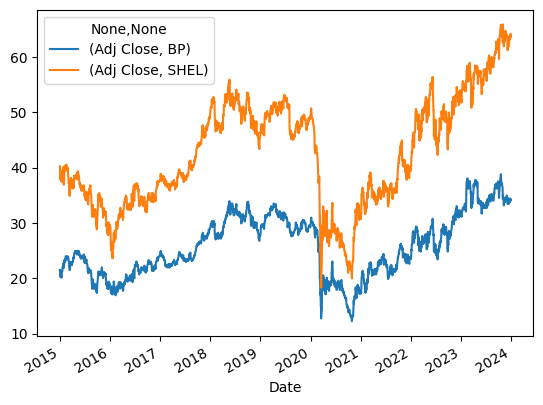

In [33]:
# Download data
tickers = ['SHEL', 'BP']
data = yf.download(tickers, start='2015-01-01', end='2023-12-31')
data.head()
data.index = pd.to_datetime(data.index)
data.reset_index(inplace=True)
data.plot(x = "Date", y = ["Adj Close"])

# Calculate log prices
data['Log_SHEL'] = np.log(data['Adj Close']['SHEL'])
data['Log_BP'] = np.log(data['Adj Close']['BP'])

# S1 = data['Adj Close']['SHEL']
# S2 = data['Adj Close']['BP']

# Calculate daily returns
returns = data['Adj Close'].pct_change().dropna()

# Calculate the correlation of daily returns between PayPal and Visa
correlation_energy_return = returns.corr()
correlation_energy = np.corrcoef(data['Log_SHEL'], data['Log_BP'])[0, 1]
print(f"--- Correlation Result---")
print(f"Correlation of Log Price between BP and SHEL:, {correlation_energy:.4f}")
print("\n--- Correlation Matrix of returns for energy stocks---")
print(correlation_energy_return)

In [34]:
X = data['Log_SHEL'].values.reshape(-1, 1)
Y = data['Log_BP'].values

# Create and fit the Linear Regression model
model = LinearRegression()
model.fit(X, Y)

# Predict Log_BP using the fitted model
Y_pred = model.predict(X)

# Calculate residuals (actual Y - predicted Y)
residuals = Y - Y_pred
data['Residuals'] = residuals

In [35]:
residuals_series = pd.Series(residuals)

adf_test = adfuller(residuals_series.dropna())
print('ADF Statistic:', adf_test[0])
print('p-value:', adf_test[1])

ADF Statistic: -4.251534529777709
p-value: 0.0005383489067803897


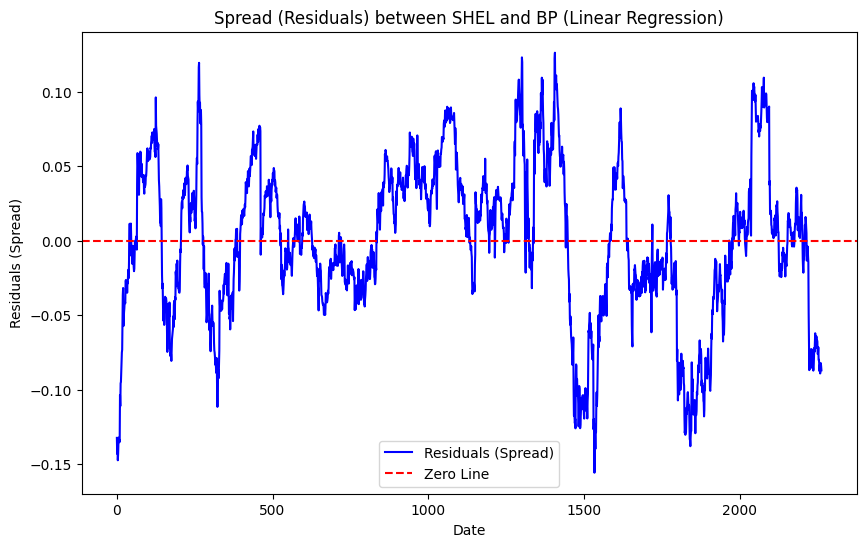

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Residuals'], label='Residuals (Spread)', color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Line')
plt.title('Spread (Residuals) between SHEL and BP (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Residuals (Spread)')
plt.legend()
plt.show()

### Next, we apply MLE to find the best investment ratio for these 2 assets.

In [37]:
def ou_log_likelihood(params, SHEL, BP, dt):
    beta = params[0]  
    alpha = 1 
    spread = alpha * SHEL - beta * BP
    diff = np.diff(spread)
    
    mu = np.mean(diff)
    sigma = np.std(diff)
    print(sigma**2)

    log_likelihood = -0.5 * np.sum((diff - mu)**2 / sigma**2 + np.log(2 * np.pi * sigma**2))
    return -log_likelihood 


def find_optimal_beta(SHEL, BP, dt=1/252):
    initial_params = [1]  
    result = minimize(ou_log_likelihood, initial_params, args=(SHEL, BP, dt), method='L-BFGS-B', bounds=[(0, None)])
    return result.x[0]  

## split train and test data

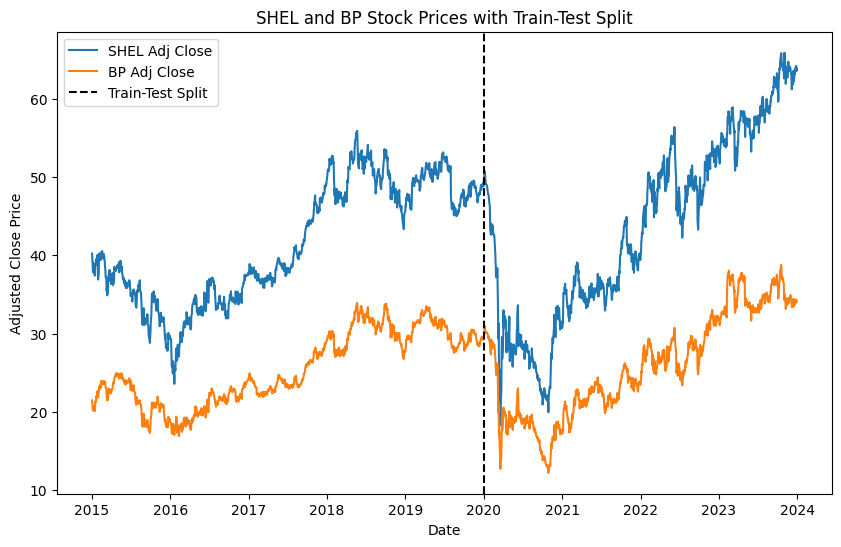

In [38]:
train_data = data[(data['Date'] >= '2015-01-01') & (data['Date'] <= '2019-12-31')]
test_data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2023-12-31')]

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(data['Date'], data['Adj Close']['SHEL'], label='SHEL Adj Close')
plt.plot(data['Date'], data['Adj Close']['BP'], label='BP Adj Close')

# Add a vertical line (dashed) to separate train and test sets
plt.axvline(pd.to_datetime('2019-12-31'), color='black', linestyle='--', label='Train-Test Split')

# Add labels and title
plt.title('SHEL and BP Stock Prices with Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()

# Show the plot
plt.show()

In [39]:
# Training period data (2015-2019)
# Calculate log prices for SHEL and BP
train_data['Log_SHEL'] = np.log(train_data['Adj Close']['SHEL'])
train_data['Log_BP'] = np.log(train_data['Adj Close']['BP'])

train_data['SHEL_pct_change'] = train_data['Adj Close']['SHEL'].pct_change()
train_data['BP_pct_change'] = train_data['Adj Close']['BP'].pct_change()

# # Set initial alpha and beta guesses and calculate the spread
# S1_train = train_data['Adj Close']['SHEL']
# S2_train = train_data['Adj Close']['BP']
# initial_alpha = 1 / S1_train[0]  # Initial guess for alpha
# initial_beta = 1 / S2_train[0]   # Initial guess for beta
# initial_params = [initial_alpha, initial_beta]

# # Time step for daily data
dt = 1 / 252

# # Spread calculation using initial alpha and beta
# spread_train = initial_alpha * train_data['Log_SHEL'] - initial_beta * train_data['Log_BP']


# Estimate OU parameters for spread in the training period
# theta_train, mu_train, sigma_train = calculate_parameters(spread_train.values, dt)

# Find optimal alpha and beta for SHEL and BP
# alpha_opt, beta_opt = find_optimal_alpha_beta(train_data['Log_SHEL'], train_data['Log_BP'])
# print(f"Optimal Alpha: {alpha_opt}, Optimal Beta: {beta_opt}")

# Optimize alpha and beta using MLE on training data
# result = minimize(log_likelihood_ab, initial_params, args=(S1_train, S2_train, mu_train, sigma_train), method='L-BFGS-B', bounds=[(0, None), (0, None)])

/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/3426042632.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Log_SHEL'] = np.log(train_data['Adj Close']['SHEL'])
/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/3426042632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Log_BP'] = np.log(train_data['Adj Close']['BP'])
/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/3426042632.py:6: SettingWithCopyWarning: 
A value is trying to be

7.117516375571413e-05
7.117516450928146e-05
0.00020707614864922224
0.00020707614517763523
6.451481714618902e-05
6.45148172172091e-05
6.445592134017269e-05
6.445592133198975e-05
6.445512894383995e-05
6.445512894384678e-05
6.445512894330222e-05
6.445512894330238e-05
Optimal Beta: 0.8216473726658432


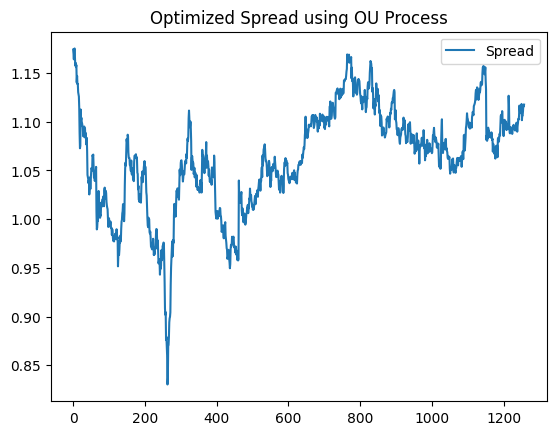

In [40]:
optimal_beta = find_optimal_beta(train_data['Log_SHEL'], train_data['Log_BP'])

# 计算价差
optimal_alpha = 1  # 固定 alpha
spread = optimal_alpha *train_data['Log_SHEL'] - optimal_beta * train_data['Log_BP']
print(f"Optimal Beta: {optimal_beta}")

# 结果可视化
import matplotlib.pyplot as plt
plt.plot(spread, label='Spread')
plt.title('Optimized Spread using OU Process')
plt.legend()
plt.show()

optimal_alpha, optimal_beta = find_optimal_beta(train_data['Log_SHEL'], train_data['Log_BP'])
print(f"Optimal Alpha: {optimal_alpha}, Optimal Beta: {optimal_beta}")

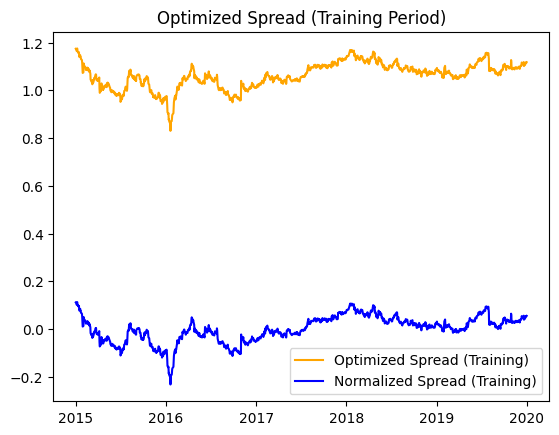

In [41]:
spread_opt_train = optimal_alpha * train_data['Log_SHEL'] - optimal_beta * train_data['Log_BP']
plt.plot(train_data['Date'], spread_opt_train, label="Optimized Spread (Training)", color='orange')
normalized_spread_train=spread_opt_train-spread_opt_train.mean()
# initial_spread_train = initial_alpha * train_data['Log_SHEL'] - initial_beta * train_data['Log_BP']
plt.plot(train_data['Date'], normalized_spread_train, label="Normalized Spread (Training)", color='blue')

plt.legend()
plt.title('Optimized Spread (Training Period)')
plt.show()

In [42]:
def generate_signals(spread, rolling_mean, rolling_std, entry_threshold, exit_threshold):
    signals = pd.DataFrame(index=spread.index)
    signals['Spread'] = spread
    signals['Position'] = 0  # 初始为 0，表示没有持仓

    for i in range(1, len(spread)):
        if spread.iloc[i] > rolling_mean.iloc[i] + entry_threshold * rolling_std.iloc[i]:
            signals.loc[spread.index[i], 'Position'] = -1  # 做空 spread
        elif spread.iloc[i] < rolling_mean.iloc[i] - entry_threshold * rolling_std.iloc[i]:
            signals.loc[spread.index[i], 'Position'] = 1   # 做多 spread
        elif abs(spread.iloc[i] - rolling_mean.iloc[i]) < exit_threshold * rolling_std.iloc[i]:
            signals.loc[spread.index[i], 'Position'] = 0   # 平仓
    return signals


In [43]:
def calculate_strategy_performance(data, spread, optimal_alpha, optimal_beta, entry_threshold, exit_threshold=1):
    # Rolling statistics
    window_size = 252  # 1-year rolling window
    if len(spread) <= window_size:
        window_size = 42

    rolling_mean = spread.rolling(window=window_size).mean()
    rolling_std = spread.rolling(window=window_size).std()

    # Generate trading signals
    signals = generate_signals(spread, rolling_mean, rolling_std, entry_threshold, exit_threshold)

    # Daily PnL
    signals['Daily_PnL'] = signals['Position'].shift(1) * (optimal_alpha * data['SHEL_pct_change'] - optimal_beta * data['BP_pct_change'])
    signals['Cumulative_PnL'] = signals['Daily_PnL'].cumsum()

    # Max Drawdown
    signals['Cumulative_Max'] = signals['Cumulative_PnL'].cummax()
    signals['Drawdown'] = signals['Cumulative_Max'] - signals['Cumulative_PnL']
    max_drawdown = signals['Drawdown'].max()

    # Annulized Return
    trading_days_per_year = 252
    average_daily_return = signals['Daily_PnL'].mean()
    daily_volatility = signals['Daily_PnL'].std()

    annualized_return = average_daily_return * trading_days_per_year
    annualized_volatility = daily_volatility * np.sqrt(trading_days_per_year)

    # Sharpe ratio
    risk_free_rate = 0
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    signals['Trade_Entry'] = (signals['Position'].shift(1) == 0) & (signals['Position'] != 0)
    signals['Trade_Exit'] = (signals['Position'].shift(1) != 0) & (signals['Position'] == 0)

    # Print the positions and trade entries/exits to verify
    # print(signals[['Position', 'Trade_Entry', 'Trade_Exit']])
    signals['Trade_PnL'] = signals['Daily_PnL'].cumsum()

    # Subtract the PnL at the start of the trade to get the PnL of each trade
    signals['Trade_PnL'] = np.where(signals['Trade_Exit'], signals['Trade_PnL'] - signals['Trade_PnL'].shift(), 0)

    # Print to verify the PnL per trade
    # print(signals[['Trade_PnL', 'Daily_PnL', 'Trade_Entry', 'Trade_Exit']])

    # Expected Gain 和 Expected Loss
    gains = signals.loc[signals['Daily_PnL'] > 0, 'Daily_PnL']
    losses = signals.loc[signals['Daily_PnL'] < 0, 'Daily_PnL']
    expected_gain = gains.mean() if not gains.empty else 0
    expected_loss = losses.mean() if not losses.empty else 0


    # Hit Ratio
    # total_trades = signals['Position_Change'].ne(0).sum()
    # profitable_trades = gains.count()
    # hit_ratio = profitable_trades / total_trades if total_trades > 0 else 0
    
    profitable_trades = (signals.loc[signals['Trade_Exit'], 'Trade_PnL'] > 0).sum()
    total_trades = signals['Trade_Exit'].sum()
    hit_ratio = profitable_trades / total_trades if total_trades > 0 else 0

    total_months = len(spread) / 30.44  # Approximate days per month
    trading_frequency = (total_trades * 12) / total_months if total_months > 0 else 0

    # print(f"Profitable trades: {profitable_trades}, Total trades: {total_trades}, Hit ratio: {hit_ratio}")

    return {
        "Entry Threshold": entry_threshold,
        "Exit Threshold": exit_threshold,
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Expected Gain": expected_gain,
        "Expected Loss": expected_loss,
        "Trading Frequency": trading_frequency,
        "Hit Ratio": hit_ratio,
        "Max Drawdown": max_drawdown,
        "spread": spread,
        "rolling_mean": rolling_mean,
        "rolling_std": rolling_std,
        "signals": signals
    }


In [44]:
entry_thresholds = [1.0, 1.5, 2.0]
exit_thresholds = [0.75, 1.0, 1.25]

test_results = []

for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        result = calculate_strategy_performance(train_data, spread_opt_train, optimal_alpha, optimal_beta, entry_threshold, exit_threshold)
        test_results.append(result)

# 将结果转换为 DataFrame 以方便查看
test_results_df = pd.DataFrame(test_results)
train_results_df = test_results_df.iloc[:, :-4]
train_results_df


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.042764,0.074851,0.571329,0.005678,-0.004871,11.614626,0.975000,0.142604
1,1.0,1.00,0.042764,0.074851,0.571329,0.005678,-0.004871,11.614626,0.975000,0.142604
2,1.0,1.25,0.042764,0.074851,0.571329,0.005678,-0.004871,11.614626,0.975000,0.142604
3,1.5,0.75,0.038284,0.056351,0.679392,0.005836,-0.004438,10.162798,0.942857,0.103547
4,1.5,1.00,0.038284,0.056351,0.679392,0.005836,-0.004438,10.162798,0.942857,0.103547
5,1.5,1.25,0.038284,0.056351,0.679392,0.005836,-0.004438,10.162798,0.942857,0.103547
6,2.0,0.75,0.012710,0.038165,0.333022,0.006350,-0.005578,4.355485,0.933333,0.076755
7,2.0,1.00,0.012710,0.038165,0.333022,0.006350,-0.005578,4.355485,0.933333,0.076755
8,2.0,1.25,0.012710,0.038165,0.333022,0.006350,-0.005578,4.355485,0.933333,0.076755


/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/132722621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Date'] = pd.to_datetime(train_data['Date'])


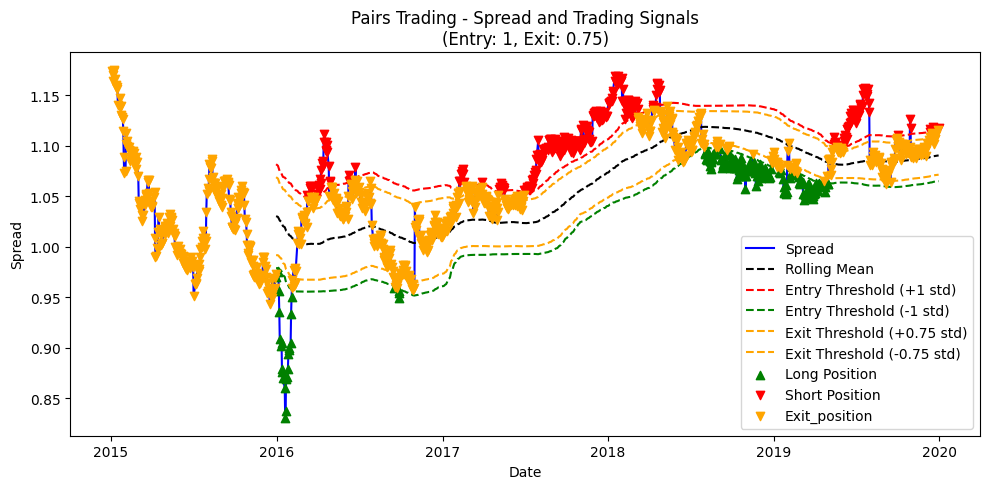

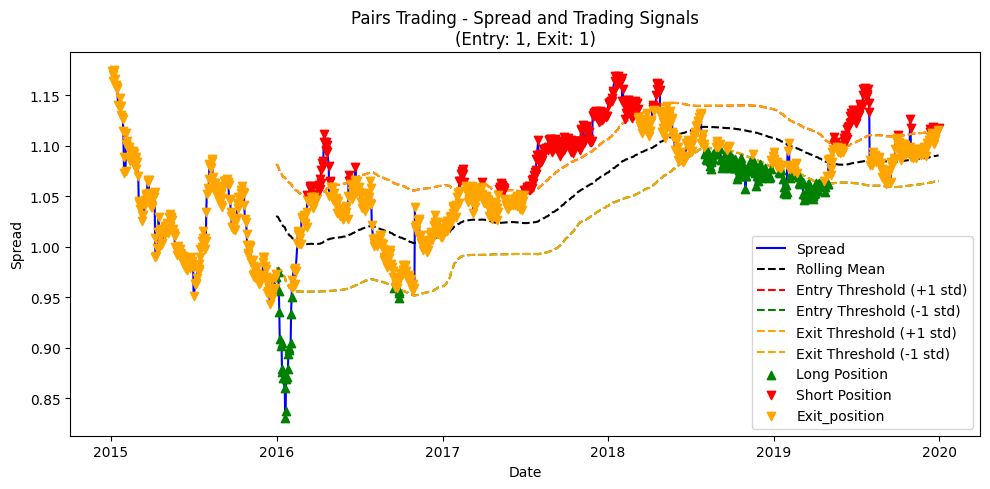

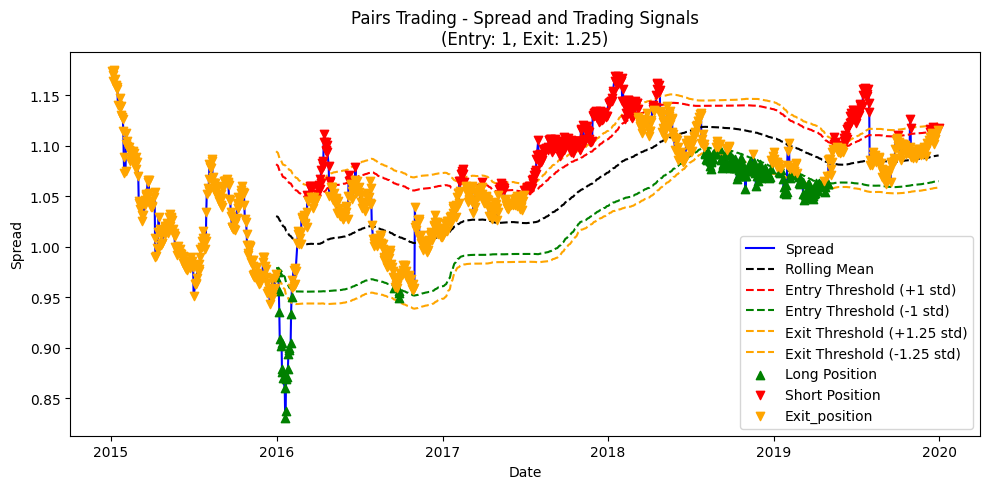

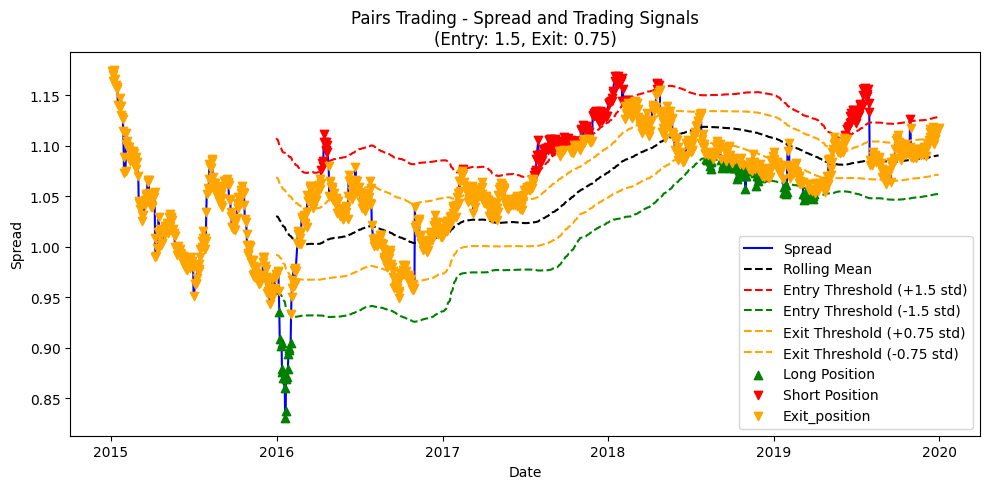

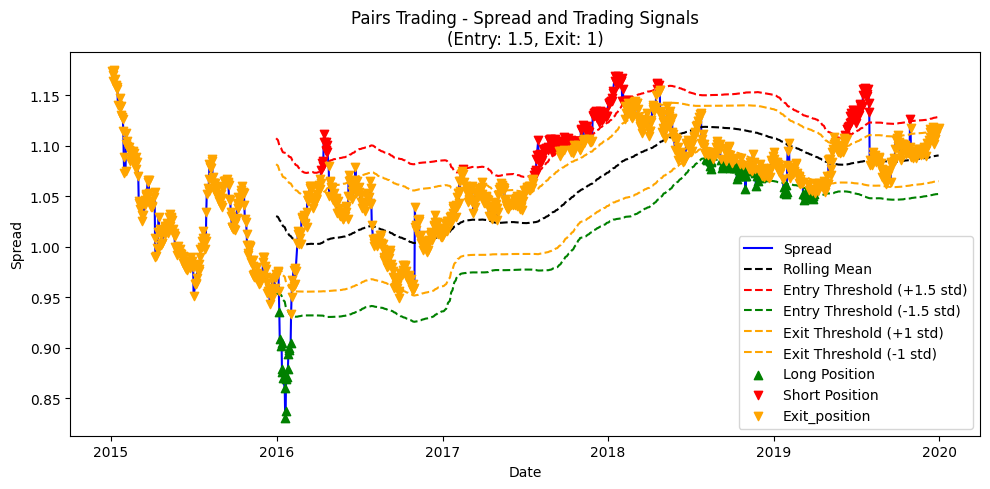

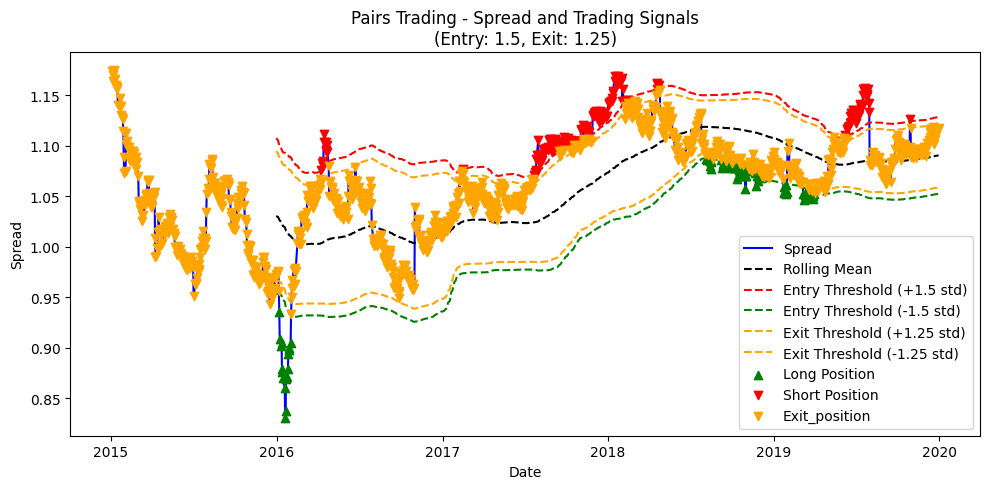

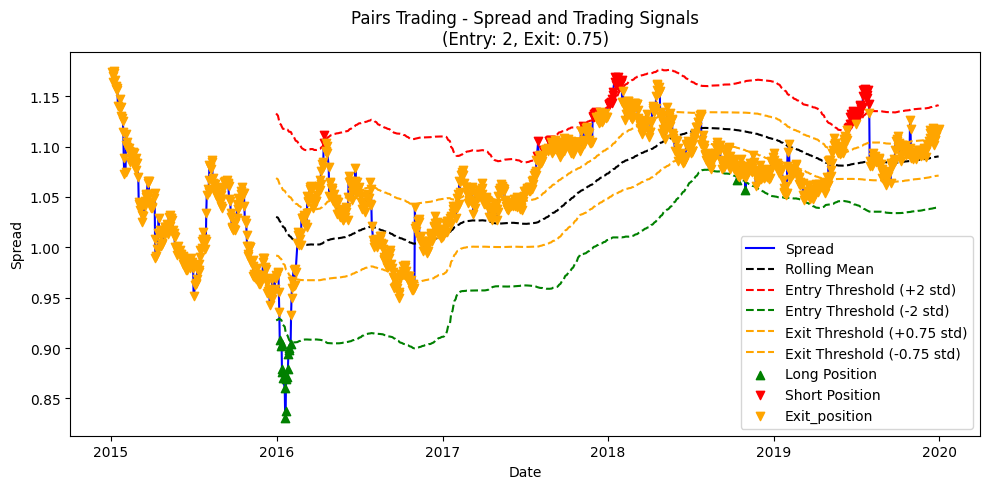

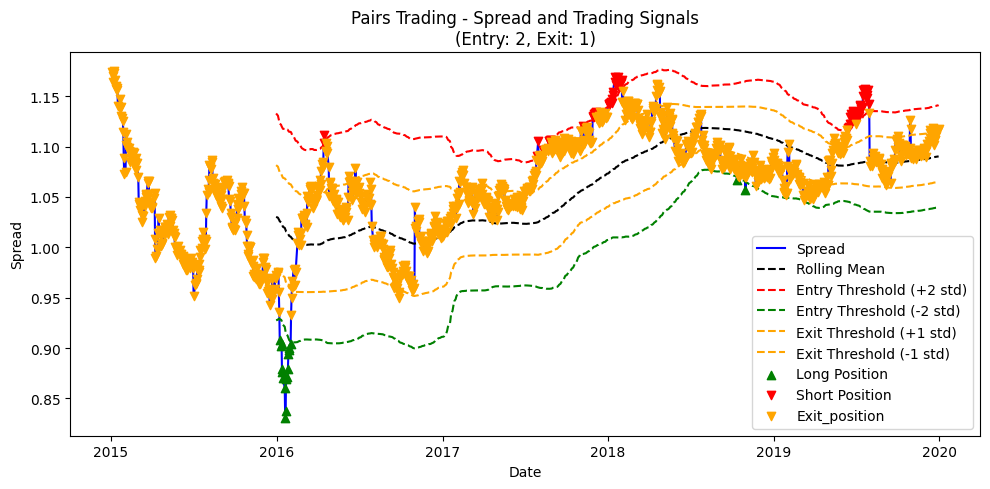

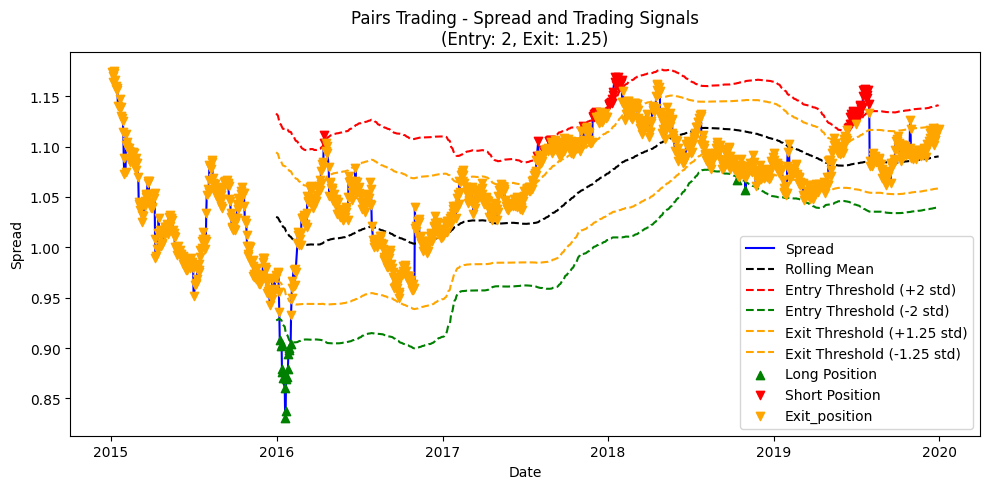

In [45]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data.set_index('Date', inplace=True)

# Define the entry and exit thresholds to test
entry_thresholds = [1, 1.5, 2]
exit_thresholds = [0.75, 1, 1.25]

# Loop through each combination of entry and exit thresholds
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        # Calculate strategy performance for current thresholds
        result = calculate_strategy_performance(train_data, spread_opt_train, optimal_alpha, optimal_beta, entry_threshold, exit_threshold)

        # Extract the spread and assign train_data index (Date) as the spread's index
        spread = result['spread']
        spread.index = train_data.index  # Ensure spread has the correct index (Date)

        rolling_mean = result['rolling_mean']
        rolling_std = result['rolling_std']
        signals_train = result['signals']

        # Ensure signals_train uses the correct index (Date)
        signals_train.index = train_data.index  # Align signals_train index with train_data

        # Start plotting
        plt.figure(figsize=(10, 5))

        # Plot the spread with train_data index (Date)
        plt.plot(spread.index, spread, label="Spread", color='blue')

        # Plot the rolling mean
        plt.plot(spread.index, rolling_mean, label="Rolling Mean", color='black', linestyle='--')

        # Plot the entry and exit thresholds
        plt.plot(spread.index, rolling_mean + entry_threshold * rolling_std, 
                 label=f'Entry Threshold (+{entry_threshold} std)', color='red', linestyle='--')
        plt.plot(spread.index, rolling_mean - entry_threshold * rolling_std, 
                 label=f'Entry Threshold (-{entry_threshold} std)', color='green', linestyle='--')
        plt.plot(spread.index, rolling_mean + exit_threshold * rolling_std, 
                 label=f'Exit Threshold (+{exit_threshold} std)', color='orange', linestyle='--')
        plt.plot(spread.index, rolling_mean - exit_threshold * rolling_std, 
                 label=f'Exit Threshold (-{exit_threshold} std)', color='orange', linestyle='--')

        # Mark the long and short positions
        long_positions = signals_train[signals_train['Position'] == 1].index
        short_positions = signals_train[signals_train['Position'] == -1].index
        exit_positions = signals_train[signals_train['Position'] == 0].index

        # Ensure positions indices are properly aligned
        plt.scatter(long_positions, spread.loc[long_positions], color='green', marker='^', label='Long Position', zorder=5)
        plt.scatter(short_positions, spread.loc[short_positions], color='red', marker='v', label='Short Position', zorder=5)
        plt.scatter(exit_positions, spread.loc[exit_positions], color='orange', marker='v', label='Exit_position', zorder=5)

        # Adding labels and legend
        plt.title(f"Pairs Trading - Spread and Trading Signals\n(Entry: {entry_threshold}, Exit: {exit_threshold})")
        plt.xlabel("Date")
        plt.ylabel("Spread")
        plt.legend()

        # Show the plot
        plt.tight_layout()
        plt.show()

## Test

In [46]:
# Split data for testing (2020-2021)
test_data = data[(data['Date'] >= '2020-01-01') & (data['Date'] <= '2023-12-31')].copy()

test_data = test_data.copy()
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data.set_index('Date', inplace=True)

# Calculate log prices for SHEL and BP
test_data.loc[:, 'Log_SHEL'] = np.log(test_data['Adj Close']['SHEL'])
test_data.loc[:, 'Log_BP'] = np.log(test_data['Adj Close']['BP'])

test_data['SHEL_pct_change'] = test_data['Adj Close']['SHEL'].pct_change()
test_data['BP_pct_change'] = test_data['Adj Close']['BP'].pct_change()

# Apply the optimal alpha and beta from the training phase
spread_opt_test = optimal_alpha * test_data['Log_SHEL'] - optimal_beta * test_data['Log_BP']

In [47]:
test_results = []
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        result = calculate_strategy_performance(test_data, spread_opt_test, optimal_alpha, optimal_beta, entry_threshold, exit_threshold)
        test_results.append(result)
    
test_results_df = pd.DataFrame(test_results)
test_results_df  = test_results_df .iloc[:, :-4]
test_results_df 

,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.005444,0.089120,0.061084,0.006593,-0.006396,6.535825,0.944444,0.142590
1,1.0,1.00,0.005444,0.089120,0.061084,0.006593,-0.006396,6.535825,0.944444,0.142590
2,1.0,1.25,0.005444,0.089120,0.061084,0.006593,-0.006396,6.535825,0.944444,0.142590
3,1.5,0.75,-0.006933,0.071279,-0.097271,0.006668,-0.006738,6.535825,0.944444,0.131037
4,1.5,1.00,-0.006933,0.071279,-0.097271,0.006668,-0.006738,6.535825,0.944444,0.131037
5,1.5,1.25,-0.006933,0.071279,-0.097271,0.006668,-0.006738,6.535825,0.944444,0.131037
6,2.0,0.75,0.021694,0.050941,0.425853,0.007763,-0.006627,5.446521,0.933333,0.060250
7,2.0,1.00,0.021694,0.050941,0.425853,0.007763,-0.006627,5.446521,0.933333,0.060250
8,2.0,1.25,0.021694,0.050941,0.425853,0.007763,-0.006627,5.446521,0.933333,0.060250


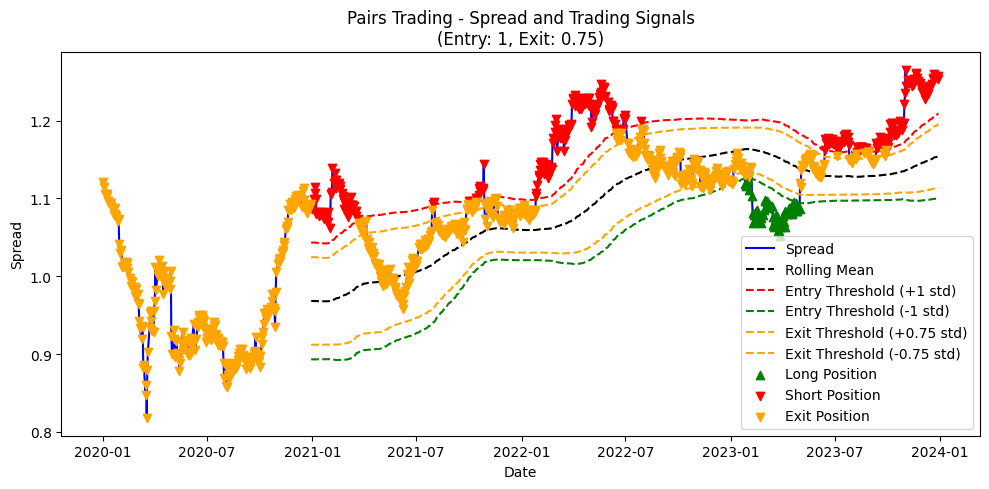

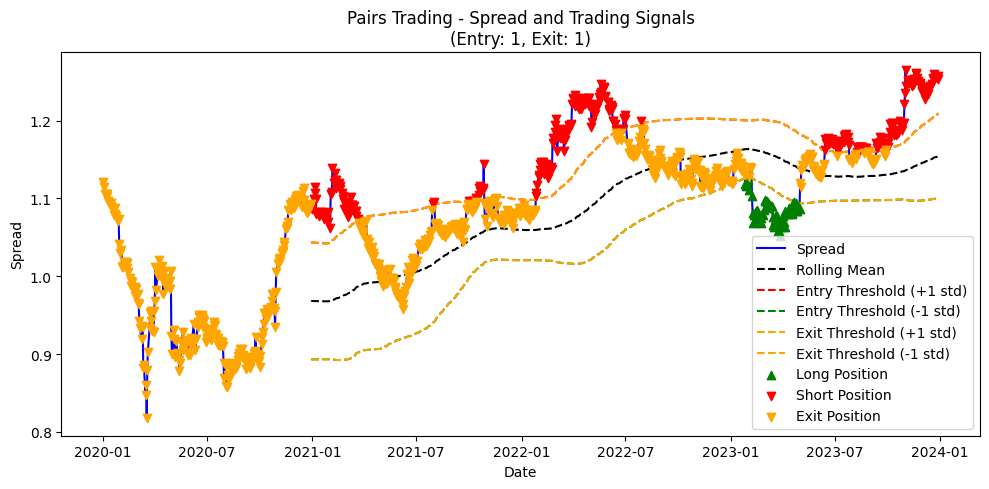

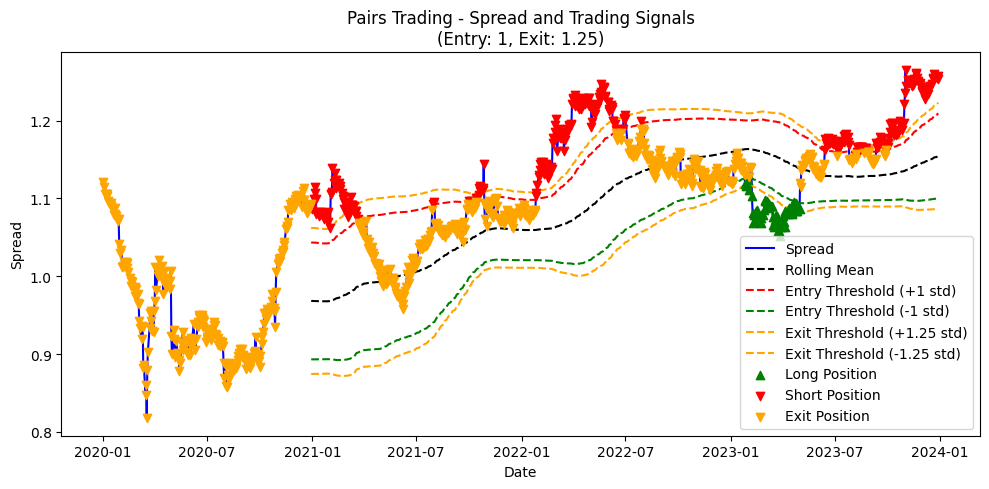

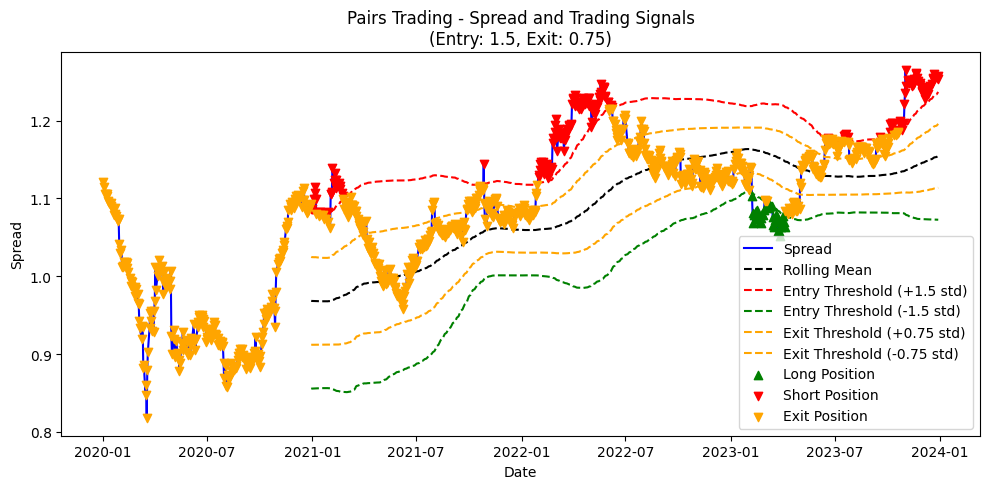

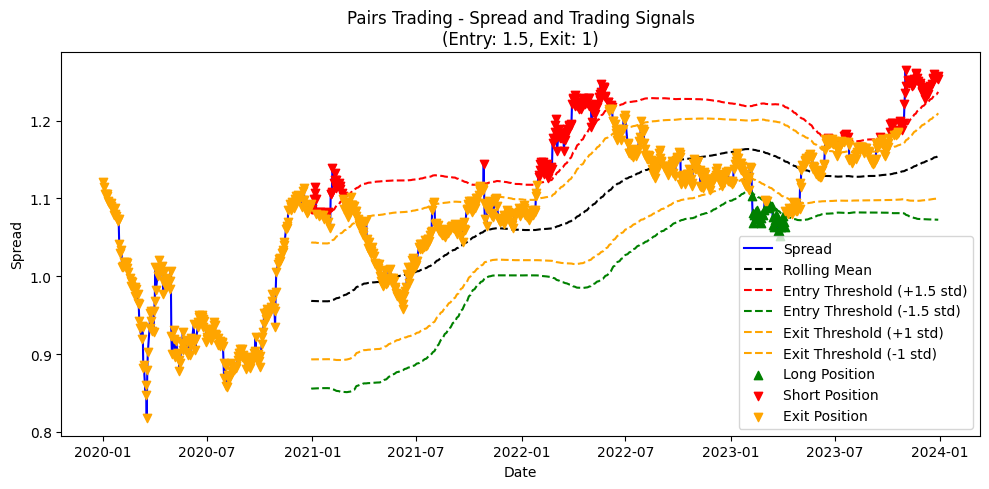

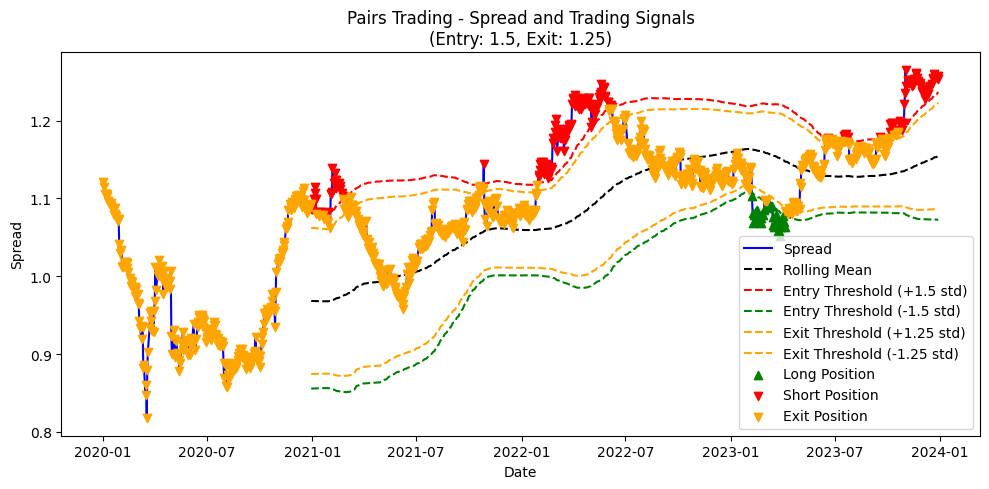

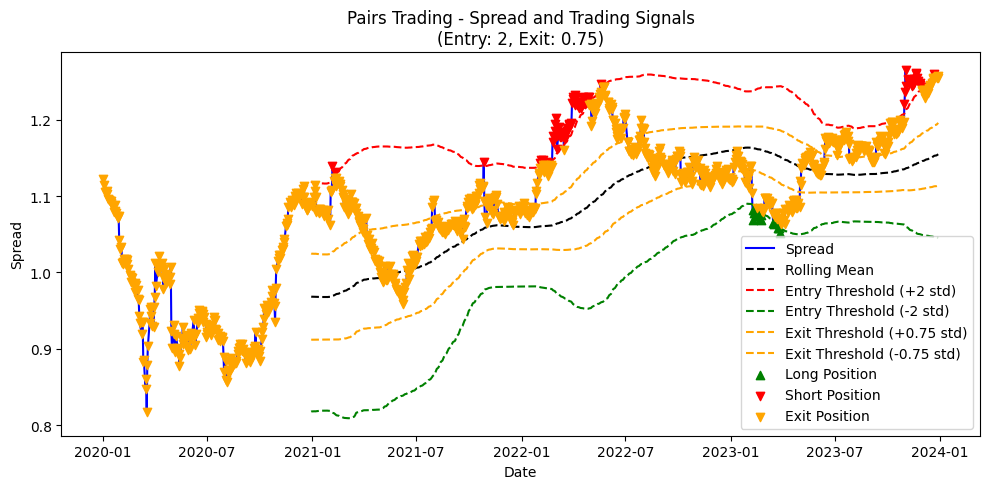

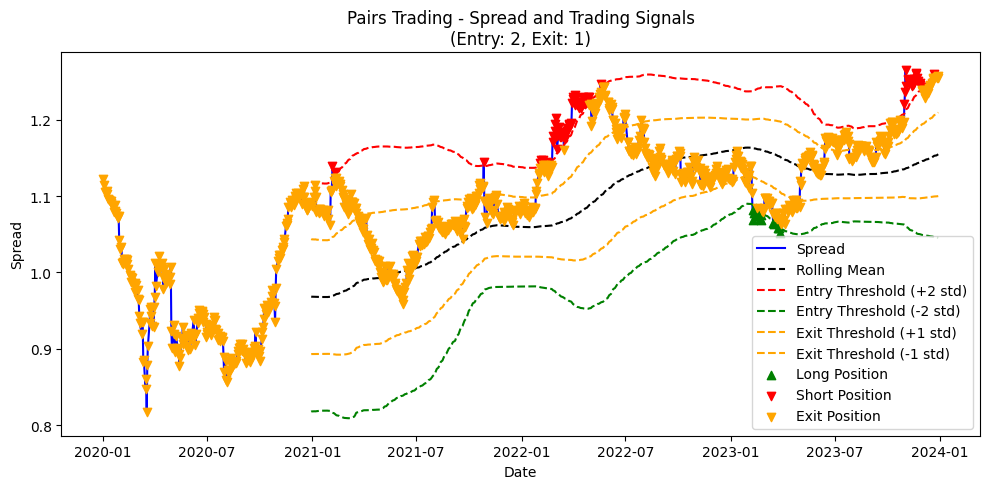

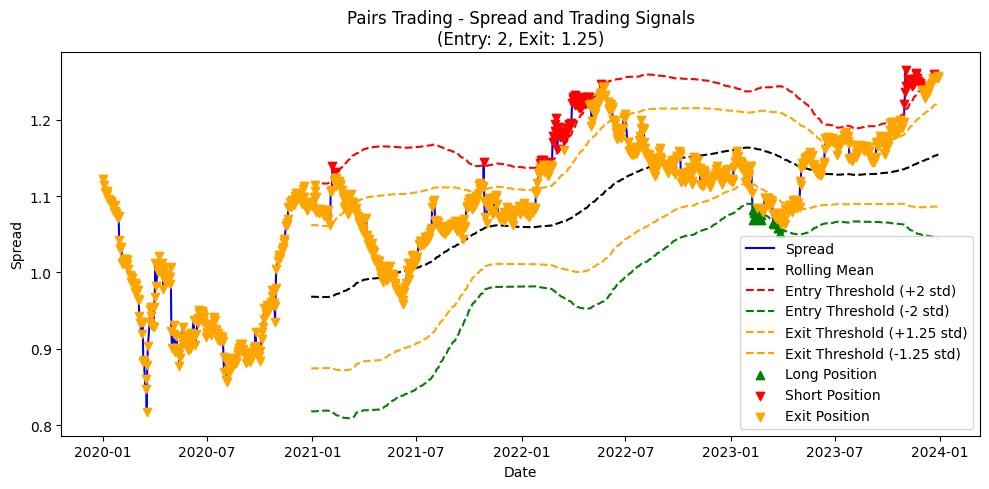

In [48]:
for entry_threshold in entry_thresholds:
    for exit_threshold in exit_thresholds:
        # Calculate strategy performance for current thresholds
        result = calculate_strategy_performance(test_data, spread_opt_test, optimal_alpha, optimal_beta, entry_threshold, exit_threshold)
        
        # Extract the spread and assign test_data index (Date) as the spread's index
        spread = result['spread']
        
        # Ensure spread has the same index as test_data
        spread = spread.reindex(test_data.index)  # Add this line to align the indices

        # Extract the necessary data for plotting
        rolling_mean = result['rolling_mean']
        rolling_std = result['rolling_std']
        signals_train = result['signals']

        # Ensure signals_train uses the correct index (Date)
        signals_train = signals_train.reindex(test_data.index)

        # Plotting
        plt.figure(figsize=(10, 5))

        # Plot the spread
        plt.plot(spread.index, spread, label="Spread", color='blue')

        # Plot the rolling mean
        plt.plot(spread.index, rolling_mean, label="Rolling Mean", color='black', linestyle='--')

        # Plot the entry and exit thresholds
        plt.plot(spread.index, rolling_mean + entry_threshold * rolling_std, 
                 label=f'Entry Threshold (+{entry_threshold} std)', color='red', linestyle='--')
        plt.plot(spread.index, rolling_mean - entry_threshold * rolling_std, 
                 label=f'Entry Threshold (-{entry_threshold} std)', color='green', linestyle='--')
        plt.plot(spread.index, rolling_mean + exit_threshold * rolling_std, 
                 label=f'Exit Threshold (+{exit_threshold} std)', color='orange', linestyle='--')
        plt.plot(spread.index, rolling_mean - exit_threshold * rolling_std, 
                 label=f'Exit Threshold (-{exit_threshold} std)', color='orange', linestyle='--')

        # Mark the long and short positions
        long_positions = signals_train[signals_train['Position'] == 1].index
        short_positions = signals_train[signals_train['Position'] == -1].index
        exit_positions = signals_train[signals_train['Position'] == 0].index

        plt.scatter(long_positions, spread.loc[long_positions], color='green', marker='^', label='Long Position', zorder=5)
        plt.scatter(short_positions, spread.loc[short_positions], color='red', marker='v', label='Short Position', zorder=5)
        plt.scatter(exit_positions, spread.loc[exit_positions], color='orange', marker='v', label='Exit Position', zorder=5)

        # Adding labels and legend
        plt.title(f"Pairs Trading - Spread and Trading Signals\n(Entry: {entry_threshold}, Exit: {exit_threshold})")
        plt.xlabel("Date")
        plt.ylabel("Spread")
        plt.legend()
        
        # Show the plot
        plt.tight_layout()
        plt.show()

In [49]:
import pandas as pd
import numpy as np

# Define the periods you want to test
period_lengths = {
    '3_months': 63,
    '6_months': 126,
    '9_months': 189,
    '1_year': 252,
    '2_year': 504,
    '3_year':756
    
}

# Define start date for the testing phase (e.g., '2020-01-01')
start_date = '2020-01-01'

# Define list to hold results
final_test_results = []

# Adjust display options to prevent truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping

# Loop through each period length
for period_name, period_days in period_lengths.items():
    # Define the end date based on the period
    end_date = pd.to_datetime(start_date) + pd.Timedelta(days=period_days)
    
    # Split the test data based on the period
    test_data_period = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)].copy()
    
    # Calculate log prices for SHEL and BP
    test_data_period['Log_SHEL'] = np.log(test_data_period['Adj Close']['SHEL'])
    test_data_period['Log_BP'] = np.log(test_data_period['Adj Close']['BP'])
    
    # Calculate percentage changes
    test_data_period['SHEL_pct_change'] = test_data_period['Adj Close']['SHEL'].pct_change()
    test_data_period['BP_pct_change'] = test_data_period['Adj Close']['BP'].pct_change()
    
    # Apply the optimal alpha and beta from the training phase
    spread_opt_test = optimal_alpha * test_data_period['Log_SHEL'] - optimal_beta * test_data_period['Log_BP']
    
    # Store the results for each threshold
    test_results = []
    for entry_threshold in entry_thresholds:
        for exit_threshold in exit_thresholds:
            result = calculate_strategy_performance(test_data_period, spread_opt_test, optimal_alpha, optimal_beta, entry_threshold, exit_threshold)
            test_results.append(result)
    
    # Create a DataFrame for the test results and store it
    test_results_df = pd.DataFrame(test_results)
    test_results_df = test_results_df.iloc[:, :-4]  # Trim unnecessary columns if needed
    
    # Append the result with period name to final results
    final_test_results.append((period_name, test_results_df))

# Display the results for each period as a DataFrame
for period_name, test_results_df in final_test_results:
    print(f"Results for {period_name}:")
    display(test_results_df)  # Use display() in Jupyter or environments that support rich output


/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/4105691169.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/4105691169.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
/var/folders/qc/y3rkgtfd5rx9y0s0c8pqdwh00000gn/T/ipykernel_96213/4105691169.py:32: RuntimeWarning: invalid value encountered in scalar divide
  sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility


Results for 3_months:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
1,1.0,1.00,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
2,1.0,1.25,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
3,1.5,0.75,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
4,1.5,1.00,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
5,1.5,1.25,-0.005529,0.002257,-2.44949,0,-0.000921,8.494884,0.0,0.000921
6,2.0,0.75,0.000000,0.000000,NaN,0,0.000000,8.494884,0.0,0.000000
7,2.0,1.00,0.000000,0.000000,NaN,0,0.000000,8.494884,0.0,0.000000
8,2.0,1.25,0.000000,0.000000,NaN,0,0.000000,8.494884,0.0,0.000000


Results for 6_months:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.234696,0.210161,1.116745,0.024239,-0.016958,25.191724,0.833333,0.134013
1,1.0,1.00,0.234696,0.210161,1.116745,0.024239,-0.016958,25.191724,0.833333,0.134013
2,1.0,1.25,0.234696,0.210161,1.116745,0.024239,-0.016958,25.191724,0.833333,0.134013
3,1.5,0.75,-0.126175,0.181211,-0.696286,0.024753,-0.020853,8.397241,0.500000,0.134013
4,1.5,1.00,-0.126175,0.181211,-0.696286,0.024753,-0.020853,8.397241,0.500000,0.134013
5,1.5,1.25,-0.126175,0.181211,-0.696286,0.024753,-0.020853,8.397241,0.500000,0.134013
6,2.0,0.75,0.076590,0.149826,0.511192,0.024838,-0.036607,12.595862,0.666667,0.059786
7,2.0,1.00,0.076590,0.149826,0.511192,0.024838,-0.036607,12.595862,0.666667,0.059786
8,2.0,1.25,0.076590,0.149826,0.511192,0.024838,-0.036607,12.595862,0.666667,0.059786


Results for 9_months:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.335198,0.182252,1.839196,0.020821,-0.015629,33.718154,0.916667,0.134013
1,1.0,1.00,0.335198,0.182252,1.839196,0.020821,-0.015629,33.718154,0.916667,0.134013
2,1.0,1.25,0.335198,0.182252,1.839196,0.020821,-0.015629,33.718154,0.916667,0.134013
3,1.5,0.75,-0.084116,0.147717,-0.569444,0.024753,-0.020853,5.619692,0.500000,0.134013
4,1.5,1.00,-0.084116,0.147717,-0.569444,0.024753,-0.020853,5.619692,0.500000,0.134013
5,1.5,1.25,-0.084116,0.147717,-0.569444,0.024753,-0.020853,5.619692,0.500000,0.134013
6,2.0,0.75,0.051060,0.122115,0.418131,0.024838,-0.036607,8.429538,0.666667,0.059786
7,2.0,1.00,0.051060,0.122115,0.418131,0.024838,-0.036607,8.429538,0.666667,0.059786
8,2.0,1.25,0.051060,0.122115,0.418131,0.024838,-0.036607,8.429538,0.666667,0.059786


Results for 1_year:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.224957,0.168511,1.334969,0.015736,-0.014309,31.489655,0.933333,0.134013
1,1.0,1.00,0.224957,0.168511,1.334969,0.015736,-0.014309,31.489655,0.933333,0.134013
2,1.0,1.25,0.224957,0.168511,1.334969,0.015736,-0.014309,31.489655,0.933333,0.134013
3,1.5,0.75,-0.064621,0.137388,-0.470356,0.017301,-0.018114,6.297931,0.666667,0.134013
4,1.5,1.00,-0.064621,0.137388,-0.470356,0.017301,-0.018114,6.297931,0.666667,0.134013
5,1.5,1.25,-0.064621,0.137388,-0.470356,0.017301,-0.018114,6.297931,0.666667,0.134013
6,2.0,0.75,0.012382,0.115395,0.107301,0.021505,-0.024106,8.397241,0.750000,0.059786
7,2.0,1.00,0.012382,0.115395,0.107301,0.021505,-0.024106,8.397241,0.750000,0.059786
8,2.0,1.25,0.012382,0.115395,0.107301,0.021505,-0.024106,8.397241,0.750000,0.059786


Results for 2_year:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.021287,0.068168,0.312277,0.007361,-0.007955,2.099310,0.500000,0.075084
1,1.0,1.00,0.021287,0.068168,0.312277,0.007361,-0.007955,2.099310,0.500000,0.075084
2,1.0,1.25,0.021287,0.068168,0.312277,0.007361,-0.007955,2.099310,0.500000,0.075084
3,1.5,0.75,0.032615,0.048668,0.670152,0.007505,-0.008197,7.347586,0.857143,0.034045
4,1.5,1.00,0.032615,0.048668,0.670152,0.007505,-0.008197,7.347586,0.857143,0.034045
5,1.5,1.25,0.032615,0.048668,0.670152,0.007505,-0.008197,7.347586,0.857143,0.034045
6,2.0,0.75,0.028151,0.023343,1.205957,0.019382,0.000000,3.148966,0.666667,0.000000
7,2.0,1.00,0.028151,0.023343,1.205957,0.019382,0.000000,3.148966,0.666667,0.000000
8,2.0,1.25,0.028151,0.023343,1.205957,0.019382,0.000000,3.148966,0.666667,0.000000


Results for 3_year:


,Entry Threshold,Exit Threshold,Annualized Return,Annualized Volatility,Sharpe Ratio,Expected Gain,Expected Loss,Trading Frequency,Hit Ratio,Max Drawdown
0,1.0,0.75,0.039575,0.073905,0.535483,0.008696,-0.008301,4.198621,0.833333,0.075084
1,1.0,1.00,0.039575,0.073905,0.535483,0.008696,-0.008301,4.198621,0.833333,0.075084
2,1.0,1.25,0.039575,0.073905,0.535483,0.008696,-0.008301,4.198621,0.833333,0.075084
3,1.5,0.75,0.045804,0.052648,0.870013,0.009730,-0.008197,5.598161,0.875000,0.034045
4,1.5,1.00,0.045804,0.052648,0.870013,0.009730,-0.008197,5.598161,0.875000,0.034045
5,1.5,1.25,0.045804,0.052648,0.870013,0.009730,-0.008197,5.598161,0.875000,0.034045
6,2.0,0.75,0.042831,0.039480,1.084881,0.029517,0.000000,2.799080,0.750000,0.000000
7,2.0,1.00,0.042831,0.039480,1.084881,0.029517,0.000000,2.799080,0.750000,0.000000
8,2.0,1.25,0.042831,0.039480,1.084881,0.029517,0.000000,2.799080,0.750000,0.000000


In [50]:
# 定义存储各个时期表现最优的标准
best_period = None
best_sharpe_ratio = -float('inf')  # 初始化一个非常低的值

# 逐个时期对比夏普比率、年化收益率和最大回撤
for period_name, test_results_df in final_test_results:
    # 取出该时期的平均夏普比率（可以取多个策略组合的平均值）
    avg_sharpe_ratio = test_results_df['Sharpe Ratio'].mean()
    avg_annual_return = test_results_df['Annualized Return'].mean()
    avg_max_drawdown = test_results_df['Max Drawdown'].mean()

    print(f"{period_name} - Avg Sharpe Ratio: {avg_sharpe_ratio}, Avg Return: {avg_annual_return}, Avg Max Drawdown: {avg_max_drawdown}")
    
    # 按照夏普比率选取最佳时期
    if avg_sharpe_ratio > best_sharpe_ratio:
        best_sharpe_ratio = avg_sharpe_ratio
        best_period = period_name

print(f"\nThe best period based on Sharpe Ratio is: {best_period}")


3_months - Avg Sharpe Ratio: -2.4494897427831783, Avg Return: -0.0036856831780771315, Avg Max Drawdown: 0.000614280529679522
6_months - Avg Sharpe Ratio: 0.31055043658332465, Avg Return: 0.0617038930036155, Avg Max Drawdown: 0.1092703677085102
9_months - Avg Sharpe Ratio: 0.5626279739555067, Avg Return: 0.100713782378754, Avg Max Drawdown: 0.1092703677085102
1_year - Avg Sharpe Ratio: 0.3239714139237875, Avg Return: 0.05757257727171762, Avg Max Drawdown: 0.1092703677085102
2_year - Avg Sharpe Ratio: 0.7294619973800986, Avg Return: 0.027350997209240734, Avg Max Drawdown: 0.03637619109299358
3_year - Avg Sharpe Ratio: 0.8301256500106311, Avg Return: 0.04273660356977079, Avg Max Drawdown: 0.03637619109299358

The best period based on Sharpe Ratio is: 3_year
